## Allen-Cahn Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### Data

In [3]:
## Data
input_data = np.load("data/AC_data_input.npy")  # (1000, 1001, 2)
y_data = np.load("data/AC_data_output.npy")  # (1000, 1001)

x_data = input_data[:, :, 1]                 # (1000, 1001)
c_data = input_data[:, :, 0]                 # (1000, 1001)

In [4]:
grid_size = 1001
n_train = 800
n_test = 200
mesh = np.linspace(-1, 1, grid_size)

x_train_np = x_data[:n_train]       # (800, 1001)
c_train_np = c_data[:n_train]       # (800, 1001)
y_train_np = y_data[:n_train]       # (800, 1001)

x_test_np = x_data[-n_test:]        # (200, 1001)
c_test_np = c_data[-n_test:]        # (200, 1001)
y_test_np = y_data[-n_test:]        # (200, 1001)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

x_train = torch.tensor(x_train_np).float()  # (800, 101)
c_train = torch.tensor(c_train_np).float()  # (800, 101)
y_train = torch.tensor(y_train_np).float()  # (800, 101)

x_test = torch.tensor(x_test_np).float()    # (200, 101)
c_test = torch.tensor(c_test_np).float()    # (200, 101)
y_test = torch.tensor(y_test_np).float()    # (200, 101)

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch:", x.shape, c.shape, y.shape)

>> Batch: torch.Size([32, 1001]) torch.Size([32, 1001]) torch.Size([32, 1001])


### Model

In [6]:
class SpectralConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes).cfloat())

    def einsum(self, inputs, weights):
        # input:  (N, in_channels, grid_size), (in_channels, out_channels, grid_size)
        # output: (N, out_channels, grid_size)
        return torch.einsum("bix,iox->box", inputs, weights)

    def forward(self, x):
        # x: [batch_size, in_channels, grid_size]
        batch_size, grid_size = x.shape[0], x.shape[-1]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batch_size, self.out_channels, grid_size // 2 + 1).cfloat().to(x.device)
        out_ft[:, :, :self.modes] = self.einsum(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=grid_size)
        return x

class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.padding = 1  # pad the domain if input is non-periodic
        self.input_layer = nn.Linear(2, width)

        self.spect1 = SpectralConv1D(width, width, modes)
        self.spect2 = SpectralConv1D(width, width, modes)
        self.spect3 = SpectralConv1D(width, width, modes)
        self.conv1 = nn.Conv1d(width, width, kernel_size=1)
        self.conv2 = nn.Conv1d(width, width, kernel_size=1)
        self.conv3 = nn.Conv1d(width, width, kernel_size=1)
        self.activation = nn.Tanh()

        self.output_layer = nn.Sequential(
            nn.Linear(width, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, c):
        x = torch.concat([x, c], dim=-1)    # (N, grid_size, 2)
        x = self.input_layer(x)             # (N, grid_size, width)
        x = x.permute(0, 2, 1)              # (N, width, grid_size)
        # x = F.pad(x, [0, self.padding])   # pad the domain if input is non-periodic

        x = self.activation(self.spect1(x) + self.conv1(x))
        x = self.activation(self.spect2(x) + self.conv2(x))
        x = self.activation(self.spect3(x) + self.conv3(x))

        # x = x[..., :-self.padding]        # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)              # (N, grid_size, width)
        x = self.output_layer(x)            # (N, grid_size, 1)
        return x.squeeze()                  # (N, grid_size)

### Training

In [8]:
# Training
def preprocess(x, c, y=None, device=device):
    x, c = x[:, :, None], c[:, :, None]     # (N, grid_size) -> (N, grid_size, 1)
    x, c = x.to(device), c.to(device)
    return (x, c) if y is None else (x, c, y.to(device))

n_epochs = 200
learning_rate = 1e-3
modes, width = 16, 64

set_seed(42)
model = FNO1D(modes, width).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.95)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_mse = 0
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = preprocess(x, c, y)
        y_pred = model(x, c)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = preprocess(x, c, y)
            y_pred = model(x, c)
            test_loss += loss_fn(y_pred, y).item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[  20/200] (lr: 9.50e-04) train_loss: 1.02e-03 | test_loss: 9.39e-04
[  40/200] (lr: 9.02e-04) train_loss: 1.84e-04 | test_loss: 2.53e-04
[  60/200] (lr: 8.57e-04) train_loss: 5.26e-05 | test_loss: 2.33e-04
[  80/200] (lr: 8.15e-04) train_loss: 4.29e-05 | test_loss: 2.28e-04
[ 100/200] (lr: 7.74e-04) train_loss: 3.32e-04 | test_loss: 6.96e-04
[ 120/200] (lr: 7.35e-04) train_loss: 1.45e-05 | test_loss: 1.13e-04
[ 140/200] (lr: 6.98e-04) train_loss: 4.76e-05 | test_loss: 1.45e-04
[ 160/200] (lr: 6.63e-04) train_loss: 2.65e-04 | test_loss: 4.72e-04
[ 180/200] (lr: 6.30e-04) train_loss: 4.28e-05 | test_loss: 1.41e-04
[ 200/200] (lr: 5.99e-04) train_loss: 1.68e-05 | test_loss: 7.72e-05


### Evaluation

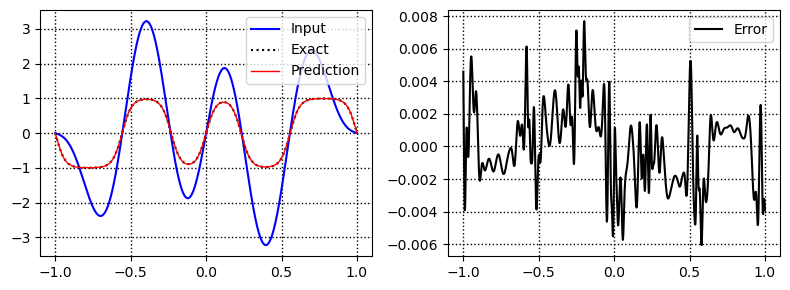

In [9]:
## Evaluation
model.eval()
with torch.no_grad():
    x, c = preprocess(x_test, c_test)
    y_pred = model(x, c)

y_pred_np = y_pred.cpu().detach().numpy()

idx = 20
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()